In [60]:
import petroeval as pet
import petroeval as pet
from petroeval import evaluate_reservoir
from petroeval import log_plot, three_plots
from petroeval import FormationEvaluation, preprocessing

import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
import catboost as cat
from catboost import CatBoostClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
import xgboost as xgb

In [61]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = './'
 
  test = pd.read_csv('./Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

In [62]:
A = np.load('penalty_matrix.npy')

def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def evaluate(model, prediction, true_label):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [79]:
#importing files
train = pd.read_csv('Train.csv', sep=';')
test = pd.read_csv('Test.csv', sep=';')

ntrain = train.shape[0]
ntest = test.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test)).reset_index(drop=True)

In [80]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology = lithology.map(lithology_numbers)

In [81]:
df = pet.preprocessing.set_mnemonics(df,
                                 GR='GR',
                                 NPHI='NPHI',
                                 RHOB='DENS',
                                 RT='RDEP')df = pet.preprocessing.set_mnemonics(df,
                                 GR='GR',
                                 NPHI='NPHI',
                                 RHOB='DENS',
                                 RT='RDEP')

In [82]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 
        'DTS', 'RXO', 'ROPA', 'RMIC', 'RSHA', 'MUDWEIGHT', 'ROP', 'DCAL']
df = drop_columns(df, *cols)
print(df.shape)

(1307297, 29)
(1307297, 19)


In [83]:
reservoir1 = FormationEvaluation(df,'GR',
                                 'NPHI',
                                 'RHOB',
                                 'RT',
                                 top=0, base=df.shape[0], cutoff=75)

#The show_table method is used to create the table and the formation evaluation parameters

table = reservoir1.show_table(baseline_default=False)
print(reservoir1)

75 will be used for evaluation
ESTIMATED PETROPHYSICAL PARAMETERS


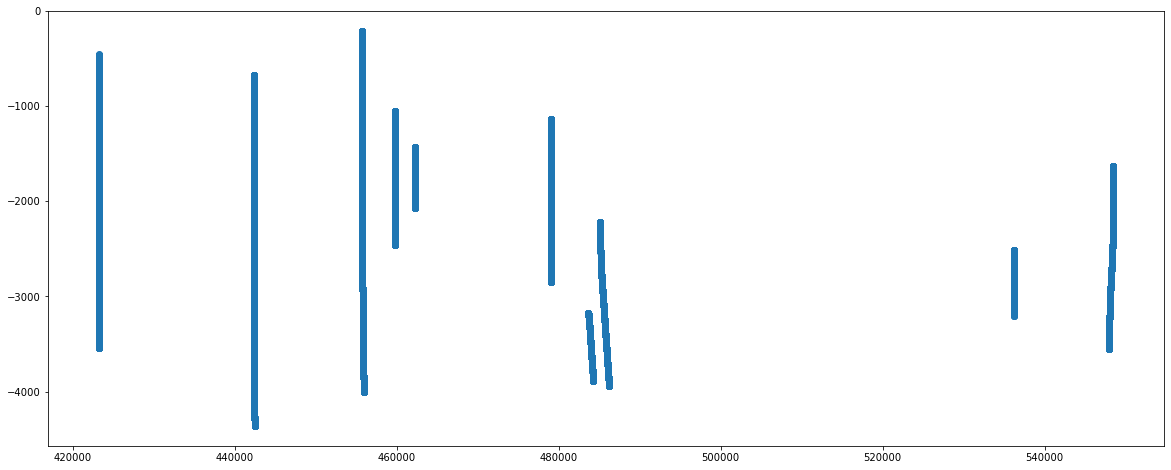

In [84]:
fig = plt.figure(figsize=(20, 8))
plt.scatter(test.X_LOC, test.Z_LOC)

In [85]:
#table.describe()

In [86]:
print(df.shape)

df['LITHO'] = table.LITHO
df['VSH'] = table.VSH
df['NET_PAY'] = table.NET_PAY
df['PHIE'] = table.PHIE
df['SW'] = table.SW

print(df.shape)

(1307297, 19)
(1307297, 24)


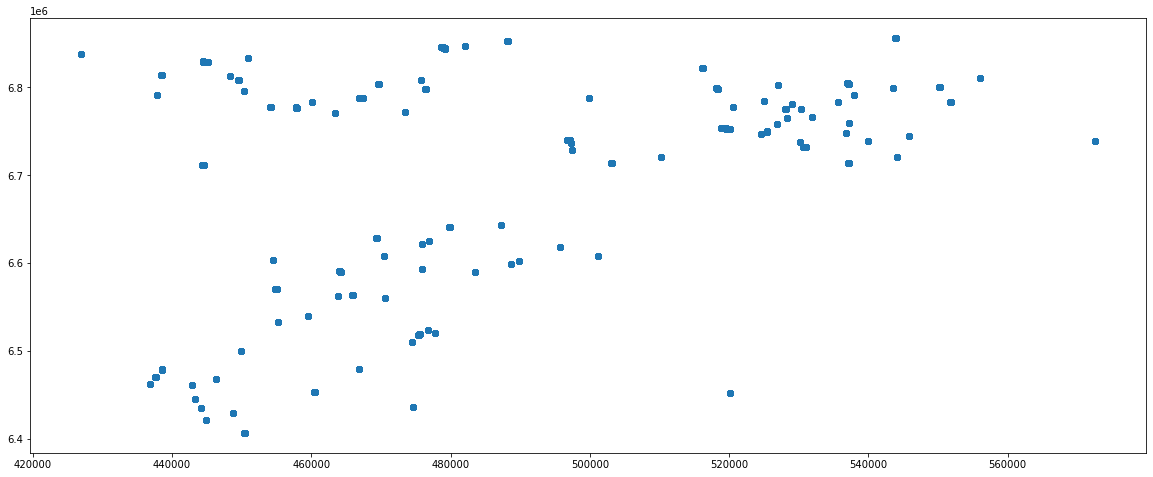

In [19]:
fig = plt.figure(figsize=(20, 8))
plt.scatter(train.X_LOC, train.Y_LOC)

In [87]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
print(df.shape)

(1307297, 26)


In [88]:
df = df.drop(['WELL', 'FORMATION', 'GROUP'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
#validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
#validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
#validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
#validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
#validation1 = validation1.reset_index(drop=True)
 
#validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
#validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
#validation2 = validation2.reset_index(drop=True)
 
 
#validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
#validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
#validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape)

(1170511, 22) (136786, 22)


In [89]:
traindata = train2
testdata = test2
 
scaler = preprocessing.StandardScaler().fit(traindata)
def scale_data(data):
  
  data = scaler.transform(data)
  #testdata = scaler.transform(testdata)
  data = pd.DataFrame(data, columns=testdata.columns)
 
  return data

In [90]:
traindata = scale_data(traindata)
testdata = scale_data(testdata)

In [91]:
class Model():
    
    def __init__(self, train, test, train_label):
        
        
        self.train = train
        self.test = test
        #self.validation = validation
        self.train_label = train_label
        #self.valid_label = valid_label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.train_label)), 
                                                                                   test_size=0.2,
                                                                                   random_state=212)
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.validation), 12))
      open_test = np.zeros((len(self.test), 12))
 
      model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2, max_depth=20)      
      #model = XGBClassifier(n_estimators=15000, max_depth=10, booster='gbtree',
                            #objective='multi:softprob', learning_rate=0.1, random_state=4080,
                            #subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            #eval_metric='mlogloss', verbose=2020, reg_lambda=20)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        #model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.validation)
        open_test += model.predict_proba(self.test)
      
      #pred = pd.DataFrame(pred/split)
      open_test= pd.DataFrame(open_test/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
      #print(show_evaluation(pred, self.valid_label))(
      make_submission(open_test, 'RF-NO-MAXDEPTH-20-FOLD1')
                  
      if plot: self.plot_feat_imp(model)
      return open_test, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [92]:
func1_= Model(traindata, testdata, lithology)
open_test1, model1 = func1_()  #max-depth=3, reg_lambda=30

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100


KeyboardInterrupt: 